# 🌎 Midiendo el impacto de aranceles EE.UU.–Perú

**Contexto**  
EE.UU. es nuestro segundo mayor cliente (42 % de las exportaciones totales, solo detrás de China). Un arancel del 10 % sobre productos peruanos encarece las ventas y reduce ingresos.

---

## 📊 Pérdidas estimadas  
- **Agropecuario**: –12,8 % → – \$516 M  
- **Petróleo & Café**: –20 % → – \$60 M  
- **Textil & Metal-mecánico**: –2 % (impacto mínimo)

---

## 🔍 Metodología  
1. Regresión de precios vs. volumen exportado  
2. Análisis de sensibilidad para cada sector  
3. Comparación de contrafactuales sin arancel

---

## 💡 Conclusión & siguiente paso  
**Diversificar mercados**:  
- Europa  
- Asia-Pacífico  

> “Apertura estratégica en nuevos destinos para compensar pérdidas”  

*Fuente: SUNAT*  


In [ ]:
## Python 3.10.16

In [1]:
# Configuraciones
import warnings
import os
from dotenv import load_dotenv

# Librerías estándar de Python
import json
import random
import unicodedata

# Procesamiento de texto y otras utilidades
import unidecode  # Para eliminar tildes
from tqdm import tqdm

# Librerías científicas y de análisis de datos
import numpy as np
import pandas as pd

# Visualización y gráficos
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
import seaborn as sns
import plotly.express as px

# Machine learning y estadísticas
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Librerías específicas para geodatos
import geopandas as gpd

# LangChain (modelos de lenguaje)
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage

# Aplicación de estilos y filtros
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
path = "/Users/elvisrojasmonguia/Documents/MCD - URP/Estadistica/primer trabajo/"
df_raw = pd.read_excel(path+"BD_EXP_2020_2024_V3.xlsx")

In [3]:
df = df_raw.copy()

In [4]:
# Cambiar los nombres de las columnas 
df.columns = [
    unidecode.unidecode(col.strip().replace(" ", "_").lower())
    for col in df.columns
]


print("Columnas actualizadas:")
print(df.columns)


Columnas actualizadas:
Index(['ruc_razon_social', 'mercado', 'departamento', 'sector_sunat',
       'via_de_transporte', 'ano', 'pes_neto_kg', 'fob_usd', 'tamano'],
      dtype='object')


In [5]:
# Contar las filas con valores negativos en la columna 'fob_usd'
num_negativos = len(df[df['fob_usd'] < 0])
print(f"El total de filas con valores negativos en 'fob_usd' es: {num_negativos}")

# Filtrar las filas con valores positivos en 'fob_usd'
df = df[df['fob_usd'] > 0]


print(f"El total de filas restantes con valores positivos en 'fob_usd' es: {len(df)}")


El total de filas con valores negativos en 'fob_usd' es: 0
El total de filas restantes con valores positivos en 'fob_usd' es: 183880


In [6]:
def analyze_columns(data, columns=None, sortby="Unique Values", include_random_values=True):
    if columns is None:
        columns = data.columns
        
    # Crear el DataFrame de información
    info_data = pd.DataFrame({
        'Variable': columns,
        'Unique Values': [data[col].nunique() for col in columns],
        'Null Count': [data[col].isnull().sum() for col in columns],
        'Null Percentage': [round(data[col].isnull().sum() / len(data) * 100, 5) for col in columns],
        'Type': ["Numeric" if pd.api.types.is_numeric_dtype(data[col]) else "Categorical" for col in columns],
        'Data Type': [data[col].dtype for col in columns]  # Agregada la columna con el dtype de cada variable
    })

    # Añadir una columna de valores aleatorios si se especifica
    if include_random_values:
        info_data['Random Value'] = [
            random.choice(data[col].dropna().values) if not data[col].isnull().all() else np.nan for col in columns
        ]

    # Ordenar por la columna especificada
    info_data = info_data.sort_values(by=sortby, ascending=True)
    
    print(f"Resumen de las {len(info_data)} columnas procesadas:\n")
    return info_data


In [7]:
info_data = analyze_columns(df, sortby="Variable").sort_values(["Type", "Null Percentage"], ascending=False)
info_data

Resumen de las 9 columnas procesadas:



,Variable,Unique Values,Null Count,Null Percentage,Type,Data Type,Random Value
5,ano,5,0,0.0,Numeric,int64,2024
7,fob_usd,152153,0,0.0,Numeric,float64,3010.45
6,pes_neto_kg,122192,0,0.0,Numeric,float64,752.804
2,departamento,27,0,0.0,Categorical,object,LIMA METROPOLITANA
1,mercado,207,0,0.0,Categorical,object,Estados Unidos
0,ruc_razon_social,18882,0,0.0,Categorical,object,20481065799-DOMINUS S.A.C
3,sector_sunat,39,0,0.0,Categorical,object,TEXTIL
8,tamano,4,0,0.0,Categorical,object,PEQUEÑO
4,via_de_transporte,9,0,0.0,Categorical,object,Aerea


## EDA 

In [8]:
# Función para eliminar tildes
def quitar_tildes(texto):
    if isinstance(texto, str):
        return ''.join(c for c in unicodedata.normalize('NFD', texto)
                       if unicodedata.category(c) != 'Mn')
    return texto

# Normalización de datos
df['departamento']  = df['departamento'].replace('SIN UBIGEO', 'NO REPORTADO')
df['sector_sunat']    = df['sector_sunat'].str.upper().str.strip()
df['via_de_transporte'] = df['via_de_transporte'].str.capitalize()

vars = ['mercado', 'via_de_transporte', 'departamento', 'sector_sunat']
for col in vars:
    df[col] = df[col].apply(quitar_tildes)

# dividir en ruc y razon social
df[['ruc', 'razon_social']] = df['ruc_razon_social'].str.split('-', n=1, expand=True)

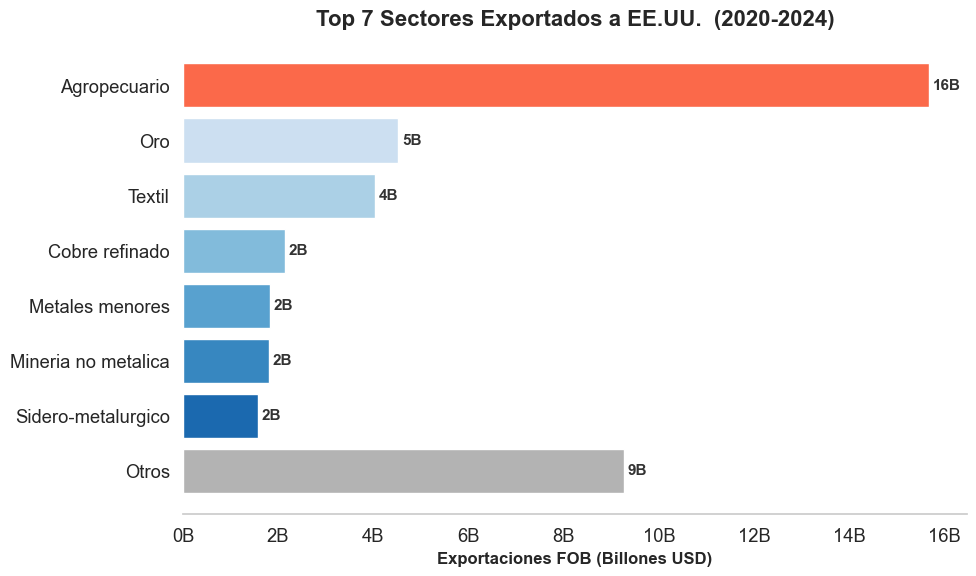

In [9]:
# Filtrar exportaciones a Estados Unidos y año 2020=2024
df_us2024 = df[
    (df['mercado'] == 'Estados Unidos')
].copy()

# Agrupar FOB por sector
sector_totals = (
    df_us2024
    .groupby('sector_sunat', as_index=False)['fob_usd']
    .sum()
)

# Normalizar nombres a formato oración
sector_totals['sector_sunat'] = sector_totals['sector_sunat'].str.capitalize()

# Ordenar y separar top sectores
howmanysects = 7
sector_totals = sector_totals.sort_values('fob_usd', ascending=False)
top5 = sector_totals.head(howmanysects).copy()
others_sum = sector_totals['fob_usd'].iloc[howmanysects:].sum()

# Crear DataFrame final con la barra "Otros"
df_plot = pd.concat([
    top5,
    pd.DataFrame({'sector_sunat': ['Otros'], 'fob_usd': [others_sum]})
], ignore_index=True)

# Convertir a millones para etiquetas
scale_money = 1e9
df_plot['fob_millions'] = df_plot['fob_usd'] / scale_money

# --- Configuración estética ------------------------------------------------
sns.set_theme(style='whitegrid', font_scale=1.2)
palette_blues = sns.color_palette("Blues", n_colors=len(df_plot))
highlight_color = sns.color_palette("Reds", 3)[1]

# Asignar colores
colors = []
for i, sector in enumerate(df_plot['sector_sunat']):
    if sector == 'Otros':
        colors.append((0.7,0.7,0.7))
    elif sector.lower() == 'agropecuario':
        colors.append(highlight_color)  # Naranja compatible


    else:
        colors.append(palette_blues[i])

# --- Gráfico de barras horizontal ------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    y=df_plot['sector_sunat'],
    width=df_plot['fob_usd'],
    color=colors,
    edgecolor='white'
)

# Invertir el eje para mostrar el mayor arriba
ax.invert_yaxis()

# Formatear eje X en millones con sufijo "B"
scale_money = 1e9
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x/scale_money:.0f}B')
)

# Etiquetas y título
ax.set_xlabel('Exportaciones FOB (Billones USD)', fontsize=12, fontweight='bold')
ax.set_title(f"Top {howmanysects} Sectores Exportados a EE.UU.  (2020-2024)", 
             fontsize=16, fontweight='bold', pad=12)

# Anotar valores en millones enteros con sufijo M
max_fob = df_plot['fob_usd'].max()
for bar, val in zip(bars, df_plot['fob_millions']):
    ax.text(
        bar.get_width() + max_fob * 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.0f}B",
        va='center',
        ha='left',
        fontsize=11,
        fontweight='bold',
        color='#333333'
    )

# Mejoras estéticas
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.xaxis.grid(False, linestyle='--', alpha=0)
ax.yaxis.grid(False, linestyle='--', alpha=0)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Top_sectores_mas_exportados_usa_2024.png', dpi=300, bbox_inches='tight')
plt.show()


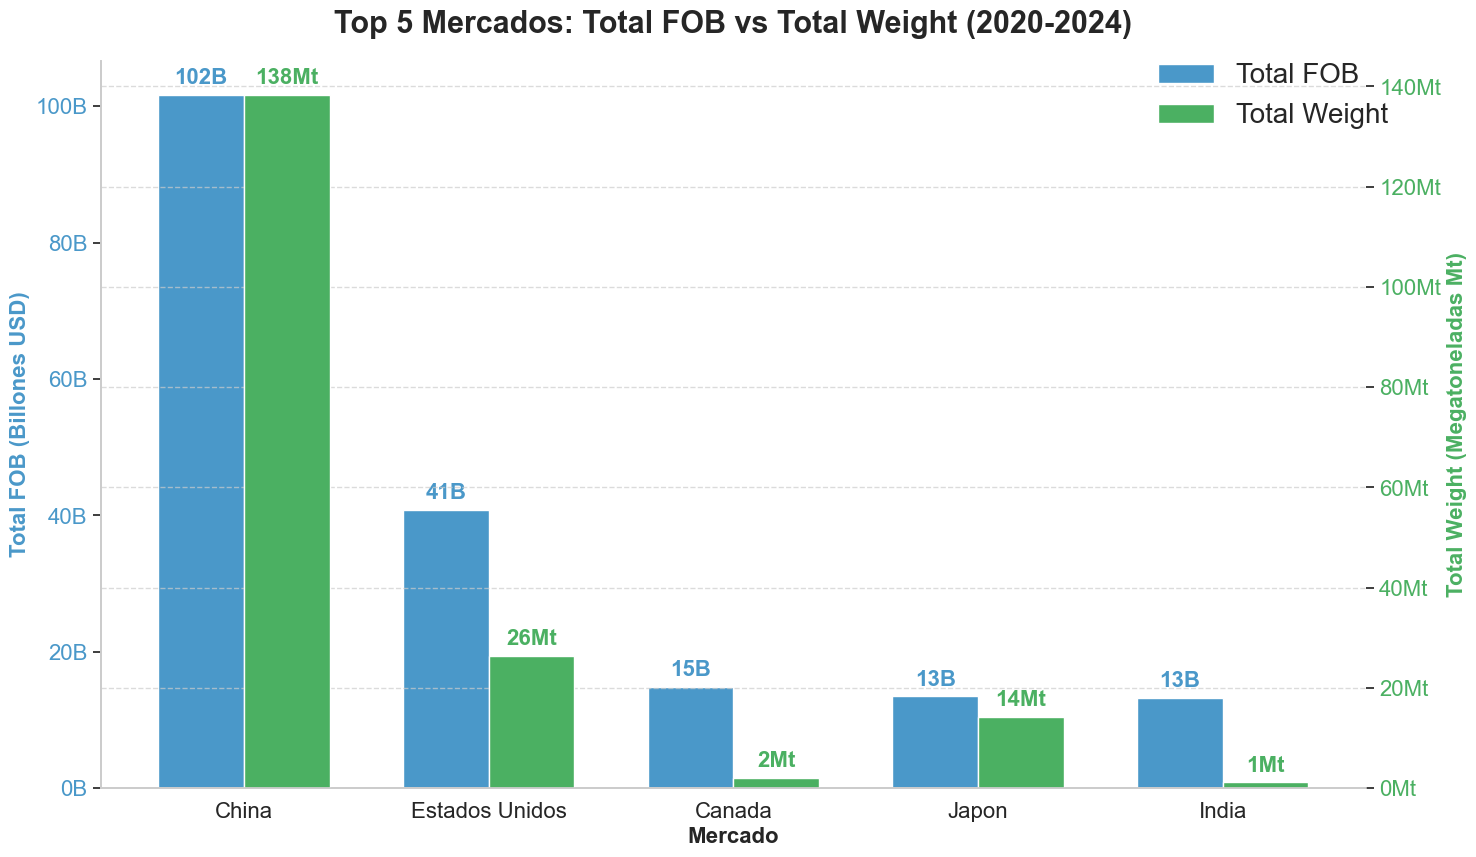

In [10]:


# -------------------- Configuración de tamaños de fuente --------------------
font_scale = 1.2             # escala general de Seaborn
fs_title = 22                # título de la figura
fs_axis_label = 16           # etiquetas de ejes (xlabel, ylabel)
fs_xtick = 16                # ticks del eje x
fs_ytick = 16                # ticks del eje y
fs_legend = 20               # leyenda
fs_annotation = 16           # anotaciones sobre barras
fs_caption = 12           # texto de caption o pie de gráfico, si lo usaras

# -------------------- Estilo general --------------------
sns.set_theme(style='whitegrid', font_scale=font_scale)

# --- 1. Agregar FOB y peso total por mercado ------------------------------
agg = (
    # df[df['ano'] == 2024] # all sample
    df.groupby('mercado')
      .agg(
         total_fob    = ('fob_usd',     'sum'),
         total_weight = ('pes_neto_kg', 'sum')
      )
      .reset_index()
)

# --- 2. Seleccionar top 5 mercados por FOB --------------------------------
Ntop = 5
top5 = agg.nlargest(Ntop, 'total_fob').reset_index(drop=True)

# --- 3. Preparar parámetros del gráfico -----------------------------------
countries = top5['mercado']
x = np.arange(len(countries))
width = 0.35

# Paleta: azules para FOB, verdes para peso
color_fob    = sns.color_palette("Blues", 4)[2]
color_weight = sns.color_palette("Greens", 4)[2]

# --- 4. Crear figura y ejes ------------------------------------------------
fig, ax1 = plt.subplots(figsize=(15, 10))

# Barras FOB (eje izquierdo)
bars1 = ax1.bar(
    x - width/2,
    top5['total_fob'],
    width,
    label='Total FOB',
    color=color_fob,
    edgecolor='white'
)
ax1.set_ylabel('Total FOB (Billones USD)', color=color_fob,
               fontsize=fs_axis_label, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_fob, labelsize=fs_ytick)
ax1.set_xticks(x)
ax1.set_xticklabels(countries, rotation=0, fontsize=fs_xtick)
ax1.set_xlabel('Mercado', fontsize=fs_axis_label, fontweight='bold')

# Formateador para eje Y1: millones con sufijo 'M'

scala_money = 1e9
ax1.yaxis.set_major_formatter(
  FuncFormatter(lambda val, pos: f'{val/scala_money:.0f}B')
)

# Anotaciones de valores en FOB encima de cada barra
for bar in bars1:
    h = bar.get_height()
    h_m = h / scala_money 
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        h + top5['total_fob'].max() * 0.01,
        f"{h_m:.0f}B",
        ha='center', va='bottom',
        fontsize=fs_annotation,
        fontweight='bold',
        color=color_fob
    )

# Eje derecho: peso total (convertir kg a toneladas T)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    top5['total_weight'],
    width,
    label='Total Weight',
    color=color_weight,
    edgecolor='white'
)
ax2.set_ylabel('Total Weight (Megatoneladas Mt)', color=color_weight,
               fontsize=fs_axis_label, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_weight, labelsize=fs_ytick)



scala_peso = 1e9
# Formateador para eje Y2: toneladas con sufijo 'T'
ax2.yaxis.set_major_formatter(
    FuncFormatter(lambda val, pos: f'{val/scala_peso:.0f}Mt')
)

# Anotaciones de valores en peso encima de cada barra
for bar in bars2:
    h = bar.get_height()
    h_t = h / scala_peso
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        h + top5['total_weight'].max() * 0.01,
        f"{h_t:.0f}Mt",
        ha='center', va='bottom',
        fontsize=fs_annotation,
        fontweight='bold',
        color=color_weight
    )

# Mostrar grid solo en eje derecho
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.grid(False)

# --- 5. Unir leyenda y mejorar detalles ------------------------------------
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()


fig.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper right',
    bbox_to_anchor=(0.95, 0.95),  # Ajusta la posición dentro del gráfico
    frameon=False,  # Activa el marco
    facecolor='white',  
    ncol=1,
    fontsize=fs_legend
)


# Quitar spines superiores y derechos
for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# Título y layout
plt.title('Top 5 Mercados: Total FOB vs Total Weight (2020-2024)',
          fontsize=fs_title, fontweight='bold', pad=20)
plt.tight_layout()
plt.subplots_adjust(bottom=0.20)

# Guardar y mostrar
plt.savefig('mercados_exportados_24_top5.png', dpi=300, bbox_inches='tight')
plt.show()


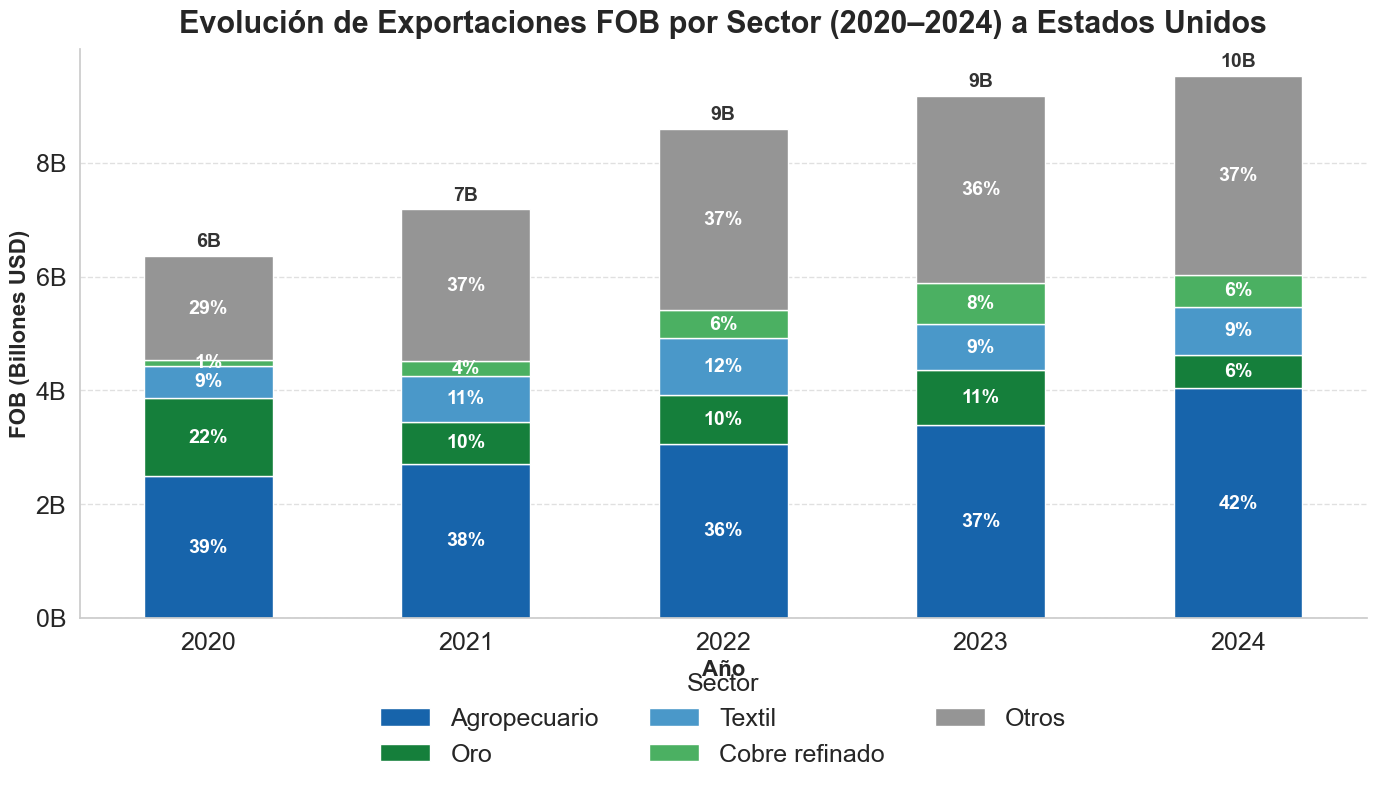

In [11]:
# -------------------- Variables de tamaño de fuente --------------------
font_scale = 1.2             # escala general de Seaborn
fs_title = 22                # título de la figura
fs_axis_label = 16           # etiquetas de ejes (xlabel, ylabel)
fs_xtick = 18                # ticks del eje x
fs_ytick = 18                # ticks del eje y
fs_legend = 18               # leyenda
fs_annotation = 14           # anotaciones dentro de barras
fs_total_label = 14          # anotaciones de totales

# -------------------- Estilo general --------------------
sns.set_theme(style='whitegrid', font_scale=font_scale)

# --- 1. Filtrar periodo 2020-2024 y agregar FOB por sector y año 2020=2024 ----------
agg = (
    df[df['mercado'] == 'Estados Unidos']
    .groupby(['ano', 'sector_sunat'])['fob_usd']
    .sum()
    .reset_index()
)

# --- 2. Identificar top 4 sectores y agrupar “Otros” ----------------------
sector_totals = (
    agg
    .groupby('sector_sunat')['fob_usd']
    .sum()
    .sort_values(ascending=False)
)
top4 = sector_totals.head(4).index.tolist()

agg['sector_group'] = np.where(
    agg['sector_sunat'].isin(top4),
    agg['sector_sunat'],
    'Otros'
)
agg['sector_group'] = agg['sector_group'].str.capitalize()

# --- 3. Pivot para stacked bar ---------------------------------------------
pivot = (
    agg
    .groupby(['ano', 'sector_group'])['fob_usd']
    .sum()
    .reset_index()
    .pivot(index='ano', columns='sector_group', values='fob_usd')
    .fillna(0)
)
cols = [s.capitalize() for s in top4] + ['Otros']
pivot = pivot[cols]

# --- 4. Palette minimalista --------------------------------------------
# Extraer tonos diferenciados
blues  = sns.color_palette("Blues", 4)[2:]
greens = sns.color_palette("Greens", 4)[2:]
greys  = sns.color_palette("Greys", 3)[1:]
palette = [
    blues[1],   # sector 1
    greens[1],  # sector 2
    blues[0],   # sector 3
    greens[0],  # sector 4
    greys[0]    # Otros
]

# --- 5. Graficar stacked bar evolutivo ------------------------------------
fig, ax = plt.subplots(figsize=(14, 9))
pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=palette,
    edgecolor='white'
)

# Anotar porcentaje dentro de cada porción
for i, year in enumerate(pivot.index):
    total = pivot.loc[year].sum()
    bottom = 0
    for j, sector in enumerate(cols):
        val = pivot.loc[year, sector]
        if val > 0:
            pct = val / total
            ax.text(
                i,
                bottom + val/2,
                f"{pct:.0%}",
                ha='center',
                va='center',
                fontsize=fs_annotation,
                fontweight='bold',
                color='white'
            )
        bottom += val

# Formatear eje Y en billones con 'B'
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-9:.0f}B'))

# Anotar al final de cada barra el total FOB en billones
max_total = pivot.sum(axis=1).max()
for i, year in enumerate(pivot.index):
    total = pivot.loc[year].sum()
    total_b = round(total / 1e9)
    ax.text(
        i,
        total + max_total * 0.01,
        f"{total_b}B",
        ha='center',
        va='bottom',
        fontsize=fs_total_label,
        fontweight='bold',
        color='#333333'
    )

# --- 6. Ajustes estéticos --------------------------------------------------
ax.set_title(
    'Evolución de Exportaciones FOB por Sector (2020–2024) a Estados Unidos',
    fontsize=fs_title,
    pad=12,
    fontweight='bold'
)
ax.set_xlabel('Año', fontsize=fs_axis_label, fontweight='bold')
ax.set_ylabel('FOB (Billones USD)', fontsize=fs_axis_label, fontweight='bold')

# Ticks
ax.tick_params(axis='x', rotation=0, labelsize=fs_xtick)
ax.tick_params(axis='y', labelsize=fs_ytick)

# Leyenda en la parte inferior
handles = [
    plt.Rectangle((0,0),1,1, facecolor=palette[i], edgecolor='white')
    for i in range(len(cols))
]
ax.legend(
    handles=handles,
    labels=cols,
    title='Sector',
    loc='lower center',
    ncol=3,
    frameon=False,
    fontsize=fs_legend,
    title_fontsize=fs_legend,
    bbox_to_anchor=(0.5, -0.30)
)

# Refinar ejes y grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(bottom=0.30)
plt.savefig('evolucion_fob_sector_usa.png', dpi=300, bbox_inches='tight')
plt.show()


### treemaps  

In [44]:
 
# --- 1. Filtrar solo AGROPECUARIO y año 2020-2024 -------------------------------
df_agro2024 = df[
    (df['sector_sunat'] == 'AGROPECUARIO') 
].copy()

# --- 2. Calcular FOB en millones y agrupar mercados ------------------------
df_agro2024['fob_millions'] = df_agro2024['fob_usd'] / 1e6

fob_by_market = (
    df_agro2024
    .groupby('mercado', as_index=False)['fob_millions']
    .sum()
    .sort_values('fob_millions', ascending=False)
)

top20 = fob_by_market['mercado'].head(20).tolist()
df_agro2024['market_group'] = np.where(
    df_agro2024['mercado'].isin(top20),
    df_agro2024['mercado'],
    'Others'
)

df_grouped = (
    df_agro2024
    .groupby('market_group', as_index=False)['fob_millions']
    .sum()
    .sort_values('fob_millions', ascending=False)
)

# --- 3. Crear el treemap ---------------------------------------------------
fig_agro = px.treemap(
    df_grouped,
    path=['market_group'],
    values='fob_millions',
    color='fob_millions',
    color_continuous_scale=['#e5f5e0', '#a1d99b', '#31a354', '#006d2c'],
    hover_data={'fob_millions': ':.0f'},
)

# --- 4. Etiquetas internas y estilo ---------------------------------------
fig_agro.update_traces(
    textinfo='label+value+percent parent',
    texttemplate='<b>%{label}</b><br>%{value:.0f}M<br>%{percentParent:.0%}',
    textfont=dict(size=16, family='Arial', color='black'),
    marker=dict(cornerradius=5)
)

# --- 5. Layout y presentación ---------------------------------------------
fig_agro.update_layout(
    # title_text='A) Exportaciones Agropecuario por Mercado (FOB en Millones USD) 2024',
    # title_font_size=24,
    # title_font_family='Arial Black',
    # title_x=0.5,

    font_family='Arial',
    font_size=14,
    uniformtext=dict(minsize=14, mode='hide'),
    margin=dict(t=80, l=20, r=20, b=80),
    paper_bgcolor='white',
    coloraxis_colorbar=dict(
        title='FOB (M USD)',
        tickformat='.0f',
        ticksuffix='M',
        orientation='h',
        x=0.5,
        y=-0.1,
        xanchor='center',
        yanchor='top',
        lenmode='fraction',
        len=0.6,
        thickness=15,
        title_side='top'
    )
)

# --- 6. Guardar en html --------------------------------------------------
fig_agro.write_html('treemap_agro_2024.html')
#fig_agro.show()
 

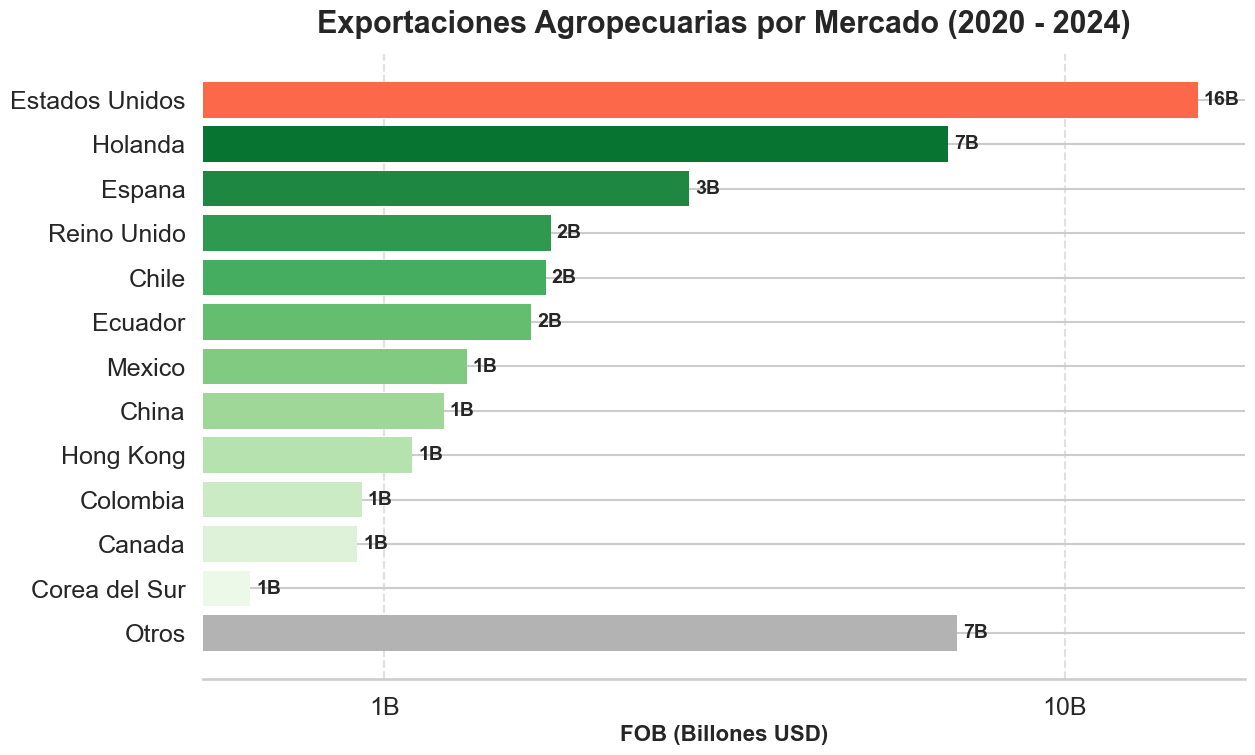

In [ ]:

# -------------------- Variables de tamaño de fuente --------------------
font_scale     = 1.2   # escala general de Seaborn
fs_title       = 22    # tamaño del título
fs_axis_label  = 16    # tamaño de etiquetas de eje
fs_xtick       = 18    # tamaño de ticks
fs_annotation  = 14    # tamaño de anotaciones

# -------------------- Estilo general --------------------
sns.set_theme(style='whitegrid', context='talk', font_scale=font_scale)

# --- 1. Filtrar sólo AGROPECUARIO y año 2020-2024 -------------------------------
df_agro2024 = df[
    (df['sector_sunat'] == 'AGROPECUARIO')
].copy()

# --- 2. Convertir FOB a billones y agrupar mercados ------------------------
df_agro2024['fob_billions'] = df_agro2024['fob_usd'] / 1e9

fob_by_market = (
    df_agro2024
    .groupby('mercado', as_index=False)['fob_billions']
    .sum()
)

# Top n mercados
salidas_paises = 12
top_markets = fob_by_market.nlargest(salidas_paises, 'fob_billions')['mercado'].tolist()

df_agro2024['market_group'] = np.where(
    df_agro2024['mercado'].isin(top_markets),
    df_agro2024['mercado'],
    'Otros'
)

df_grouped = (
    df_agro2024
    .groupby('market_group', as_index=False)['fob_billions']
    .sum()
)

# Mapear nombres largos
mapping = {
    "Corea del Sur (Republica de Corea)": "Corea del Sur",
    "Paises Bajos (Holanda)": "Holanda",
    "Republica Dominicana": "Rep. Dominicana"
}
df_grouped['market_group'] = df_grouped['market_group'].replace(mapping)

# --- 3. Forzar “Otros” al inicio y ordenar el resto de menor a mayor ------
df_otros = df_grouped[df_grouped['market_group'] == 'Otros']
df_main  = df_grouped[df_grouped['market_group'] != 'Otros']

df_main = df_main.sort_values('fob_billions', ascending=True)
df_sorted = pd.concat([df_otros, df_main], ignore_index=True)

# --- 4. Paleta minimalista + destacar EE. UU. -----------------------------
# Gris suave para “Otros” + verdes para el resto
base_palette = sns.color_palette("Greens", len(df_main))
# Color especial para EE. UU.
highlight_color = sns.color_palette("Reds", 3)[1]

# Construir paleta, reemplazando EE. UU. por el rojo
palette = []
for market, col in zip(df_sorted['market_group'], [None]*len(df_sorted)):
    if market == 'Estados Unidos':
        palette.append(highlight_color) 
    elif market == 'Otros':
        palette.append((0.7,0.7,0.7))
    else:
        # tomar next verde
        palette.append(base_palette.pop(0))

# --- 5. Graficar barras horizontales --------------------------------------
fig, ax = plt.subplots(figsize=(13, 8))
bars = ax.barh(
    y=df_sorted['market_group'],
    width=df_sorted['fob_billions'],
    color=palette,
    edgecolor='none'
)

# --- 6. Escala log en X y formateo en billones ---------------------------
ax.set_xscale('log')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}B'))

# --- 7. Anotar valores ----------------------------------------------------
for bar, val in zip(bars, df_sorted['fob_billions']):
    ax.text(
        bar.get_width() * 1.02,
        bar.get_y() + bar.get_height()/2,
        f"{val:.0f}B",
        va='center',
        ha='left',
        fontsize=fs_annotation,
        fontweight='bold'
    )

# --- 8. Etiquetas y título ------------------------------------------------
ax.set_xlabel('FOB (Billones USD)', fontsize=fs_axis_label, fontweight='bold')
ax.set_ylabel('')
ax.set_title(
    'Exportaciones Agropecuarias por Mercado (2020 - 2024)',
    fontsize=fs_title,
    fontweight='bold',
    pad=15
)

# --- 9. Ajustes estéticos -------------------------------------------------
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.6)
ax.set_axisbelow(True)
ax.tick_params(axis='y', labelsize=fs_xtick)
ax.tick_params(axis='x', labelsize=fs_xtick)

fig.subplots_adjust(top=0.85, bottom=0.15, left=0.17, right=0.95)
fig.savefig('soluciones_nuevos_mercados.png', dpi=300, facecolor='white', bbox_inches='tight')
 
plt.tight_layout()
plt.show()


In [ ]:
# --- 1. Filtrar año 2020-2024 y mercado = Estados Unidos -------------------------
df_us2024 = df[
    #(df['ano'] == 2024) &
    (df['mercado'] == 'Estados Unidos')
].copy()

# --- 2. Calcular FOB en millones y agrupar “Otros” --------------------------
df_us2024['fob_millions'] = df_us2024['fob_usd'] / 1e6

# Top 20 sectores
sector_totals = (
    df_us2024
    .groupby('sector_sunat')['fob_millions']
    .sum()
    .sort_values(ascending=False)
)


hm_sec = 12
top20 = sector_totals.head(hm_sec).index.tolist()

df_us2024['sector_group'] = np.where(
    df_us2024['sector_sunat'].isin(top20),
    df_us2024['sector_sunat'].str.capitalize(),
    'Otros Sec'
)

# Top 5 departamentos
dept_totals = (
    df_us2024
    .groupby('departamento')['fob_millions']
    .sum()
    .sort_values(ascending=False)
)

hm_deps = 5
top5_depts = dept_totals.head(hm_deps).index.tolist()

df_us2024['departamento_group'] = np.where(
    df_us2024['departamento'].isin(top5_depts),
    df_us2024['departamento'].str.capitalize(),
    'Otros Dep'
)

# --- 3. Agrupar y preparar para el treemap ---------------------------------
df_plot = (
    df_us2024
    .groupby(['sector_group','departamento_group'], as_index=False)
    ['fob_millions']
    .sum()
)

# --- 4. Crear treemap ------------------------------------------------------
fig_sector_deps = px.treemap(
    df_plot,
    path=['sector_group','departamento_group'],
    values='fob_millions',
    color='fob_millions',
    color_continuous_scale=['#e0f3db', '#a8ddb5', '#43a2ca', '#0868ac'],
    hover_data={'fob_millions':':.1f'}
)

# --- 5. Etiquetas y estilo de trazas ----------------------------------------
fig_sector_deps.update_traces(
    textinfo='label+value+percent parent',
    texttemplate=(
        '<b>%{label}</b><br>'
        '%{value:.0f}M<br>'
        '%{percentParent:.0%}'
    ),
    textfont=dict(size=16, family='Arial Black', color='black'),
    marker=dict(line=dict(width=2, color='white'))
)

# --- 6. Layout y ajustes finales -------------------------------------------
fig_sector_deps.update_layout(
    # no incluimos title_text
    font=dict(family='Arial', size=14),
    uniformtext=dict(minsize=14, mode='hide'),
    margin=dict(t=120, l=20, r=20, b=100),
    paper_bgcolor='white',
    coloraxis_colorbar=dict(
        title='FOB (M USD)',
        tickformat='.0f',
        ticksuffix='M',
        orientation='h',
        x=0.5,
        y=-0.12,
        xanchor='center',
        yanchor='top',
        lenmode='fraction',
        len=0.6,
        thickness=15,
        title_side='top'
    )
)

# --- 6. Guardar y mostrar --------------------------------------------------
fig_sector_deps.write_html('treemap_sectores_departamento.html')
fig_sector_deps.show()
 


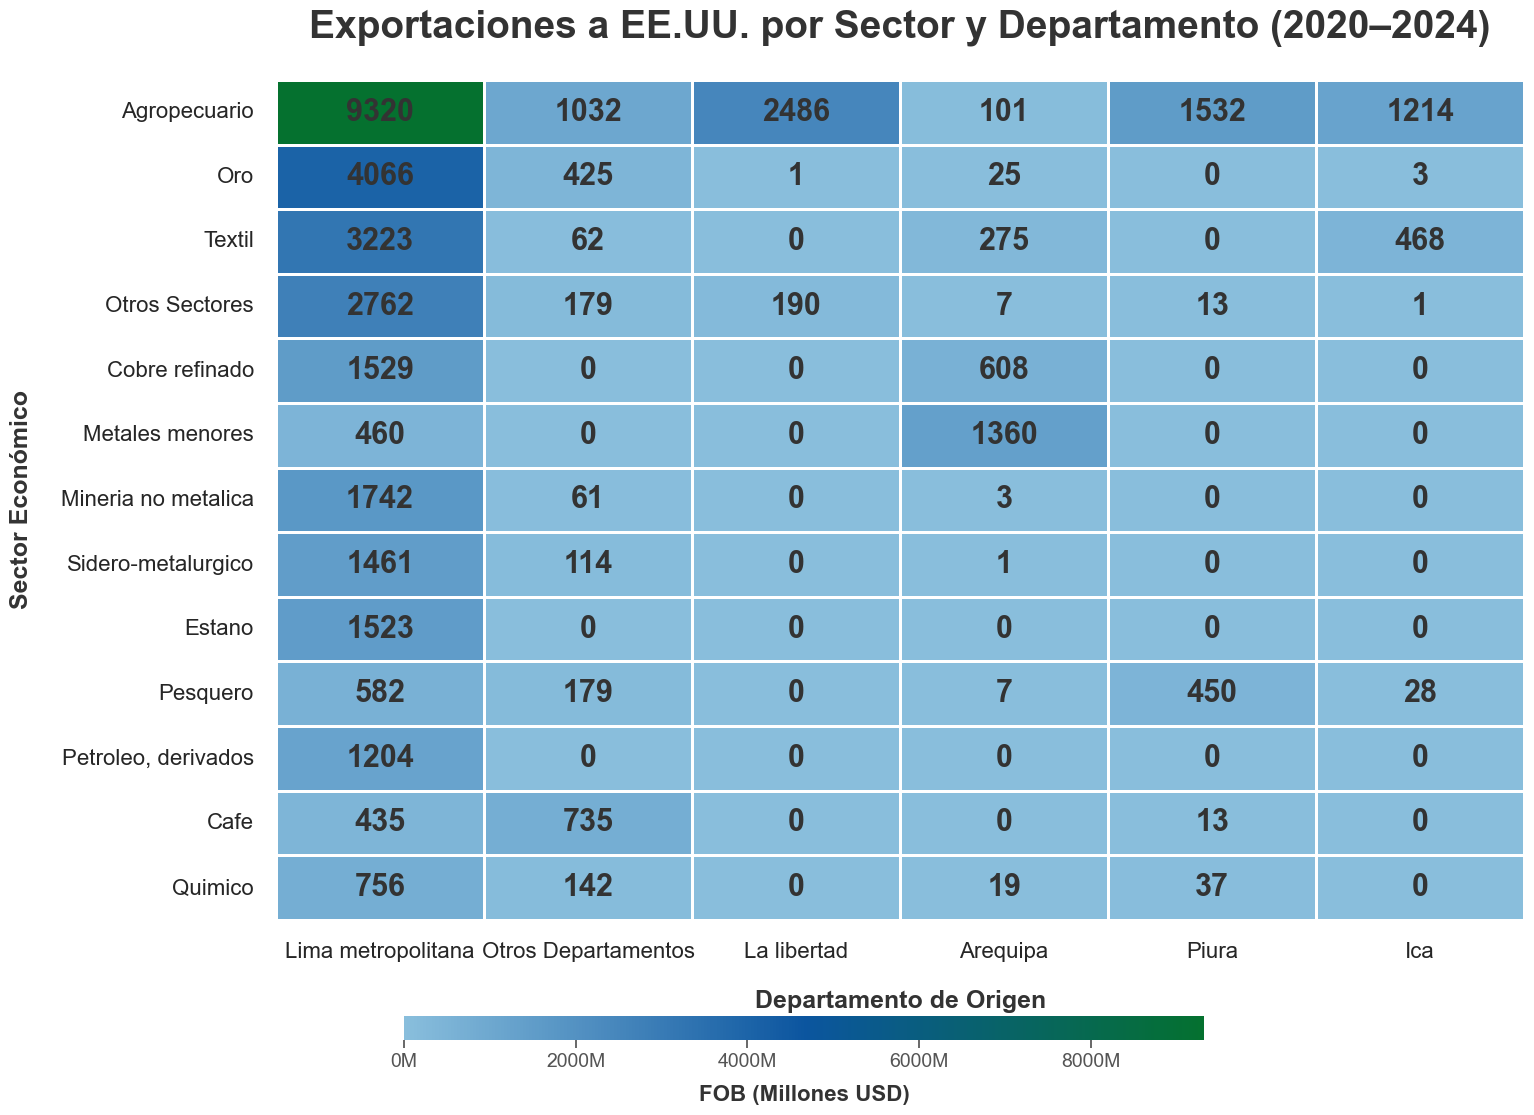

In [ ]:
# -------------------- Variables de tamaño de fuente --------------------
font_scale      = 1.4   # escala general de Seaborn
fs_title        = 28   # título principal
fs_axis_label   = 18    # etiquetas de ejes (xlabel, ylabel)
fs_tick_labels  = 16    # tamaño de ticks en ambos ejes
fs_annot        = 22    # tamaño de anotaciones en celdas
fs_cbar_label   = 16    # etiqueta barra de color
fs_cbar_ticks   = 14    # ticks barra de color

# -------------------- Estilo global --------------------
sns.set_theme(style="white", font_scale=font_scale)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "axes.edgecolor":   "#333333",
    "axes.labelcolor":  "#333333",
    "text.color":       "#333333",
    "font.family":      "Arial"
})

# --- 1. Filtrar años 2020–2024 y mercado = Estados Unidos ---------------
df_us = df[
    (df['mercado'] == 'Estados Unidos') &
    (df['ano'].between(2020, 2024))
].copy()

# --- 2. Calcular FOB en millones ---------------------------------------
df_us['fob_millions'] = df_us['fob_usd'] / 1e6

# --- 3. Encontrar top 12 sectores y top 5 departamentos ----------------
sector_totals = df_us.groupby('sector_sunat')['fob_millions'].sum().sort_values(ascending=False)
top_sectors   = sector_totals.head(12).index.tolist()

dept_totals   = df_us.groupby('departamento')['fob_millions'].sum().sort_values(ascending=False)
top_depts     = dept_totals.head(5).index.tolist()

# --- 4. Clasificar sectores y departamentos fuera del top -------------- 
df_us['sector_group']     = np.where(df_us['sector_sunat'].isin(top_sectors),
                                     df_us['sector_sunat'].str.capitalize(),
                                     'Otros Sectores')
df_us['departamento_group']= np.where(df_us['departamento'].isin(top_depts),
                                     df_us['departamento'].str.capitalize(),
                                     'Otros Departamentos')

# --- 5. Agregar totales por combinación ---------------------------------
df_plot = (df_us
    .groupby(['sector_group','departamento_group'], as_index=False)
    ['fob_millions']
    .sum()
)

# --- 6. Pivot para heatmap ---------------------------------------------
df_pivot = df_plot.pivot(
    index='sector_group',
    columns='departamento_group',
    values='fob_millions'
).fillna(0)

# Ordenar por totales
df_pivot = df_pivot.loc[df_pivot.sum(axis=1).sort_values(ascending=False).index,
                        df_pivot.sum(axis=0).sort_values(ascending=False).index]

# --- 7. Preparar paleta estéticamente contrastada -----------------------
# De azul a verde, con gris para "Otros Departamentos"
blues = sns.color_palette("Blues", 6)
greens = sns.color_palette("Greens", 6)
# Crear map personalizado (más contraste en extremos)
custom_cmap = sns.blend_palette([blues[2], blues[-1], greens[-1]], as_cmap=True)
main_color = blues[-1]

# --- 8. Dibujar heatmap --------------------------------------------------
fig, ax = plt.subplots(figsize=(16, 12))
hm = sns.heatmap(
    df_pivot,
    cmap=custom_cmap,
    annot=True,
    fmt=".0f",
    linewidths=2,
    linecolor="white",
    cbar=False,              # barra de color personalizada
    annot_kws={
        "size": fs_annot,
        "weight": "bold",
        "color": "#333333"
    },
    ax=ax
)

# --- 9. Título y etiquetas ------------------------------------------------
ax.set_title(
    'Exportaciones a EE.UU. por Sector y Departamento (2020–2024)',
    fontsize=fs_title,
    fontweight="bold",
    pad=30
)
ax.set_xlabel('Departamento de Origen', fontsize=fs_axis_label, fontweight="bold", labelpad=20)
ax.set_ylabel('Sector Económico',     fontsize=fs_axis_label, fontweight="bold", labelpad=20)

# --- 10. Ticks y desaparición de spines -----------------------------------
ax.tick_params(axis='x', labelsize=fs_tick_labels, rotation=0, pad=10)
ax.tick_params(axis='y', labelsize=fs_tick_labels, rotation=0, pad=10)
sns.despine(left=True, bottom=True, right=True, top=True)

# --- 11. Colorbar manual --------------------------------------------------
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(hm.get_children()[0], cax=cbar_ax, orientation="horizontal",
                    format=FormatStrFormatter("%.0fM"))
cbar.set_label("FOB (Millones USD)", fontsize=fs_cbar_label, weight="bold", color="#333333", labelpad=10)
cbar.ax.tick_params(labelsize=fs_cbar_ticks, color="#555555", labelcolor="#555555")
cbar.outline.set_visible(False)

# --- 12. Ajuste final de layout ------------------------------------------
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.17, right=0.95)
plt.savefig('heatmap_us_2020_2024.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()


## Calculo de impactos

In [ ]:
# ======================
# FEATURE ENGINEERING 
# ======================
df_ml = df.copy()

df_ml['fob_usd']       = pd.to_numeric(df_ml['fob_usd'], errors='coerce')
df_ml['pes_neto_kg']   = pd.to_numeric(df_ml['pes_neto_kg'], errors='coerce')
df_ml['valor_por_kg'] = df_ml['fob_usd'] / df_ml['pes_neto_kg']


df_ml = df_ml.assign(
    ln_fob   = np.log(df_ml['fob_usd']),
    ln_kg    = np.log(df_ml['pes_neto_kg']),
    ln_valor = np.log(df_ml['valor_por_kg'])
)



In [ ]:

print("Cantidad de valores negativos cuando se convierte a logaritmos:")
len(df_ml[df_ml['fob_usd'] < 1 ]) ,   len(df_ml[df_ml['pes_neto_kg'] < 1 ])

Cantidad de valores negativos cuando se convierte a logaritmos:


(1355, 3546)

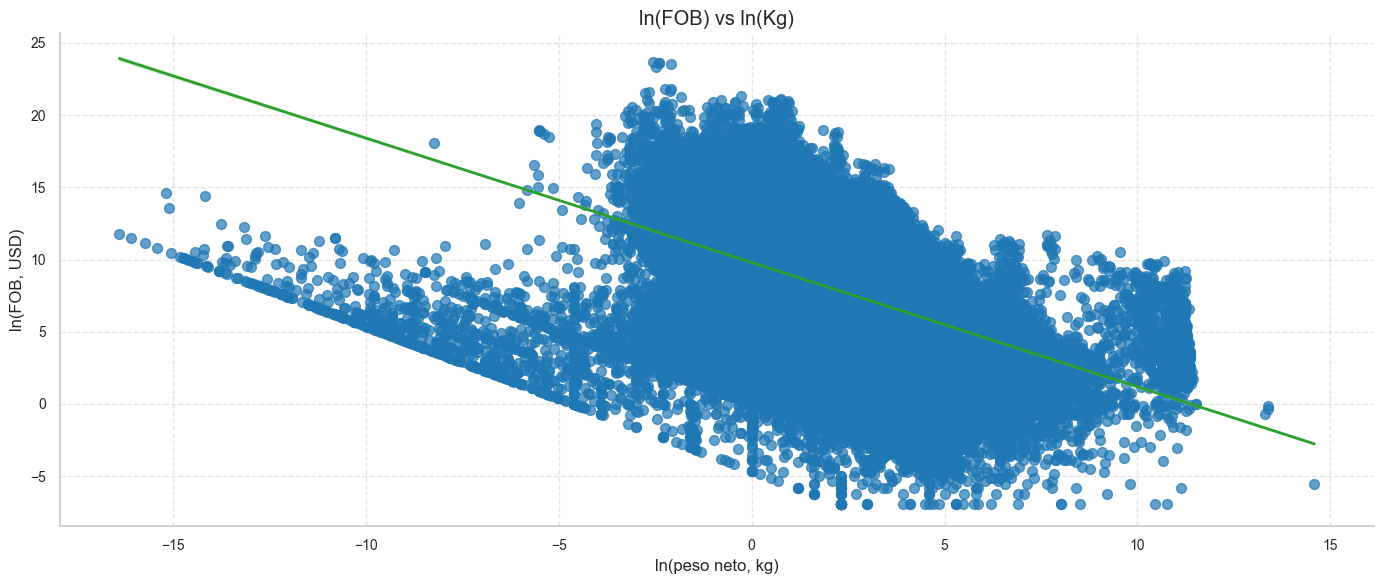

In [ ]:
# Configuramos estilo base
sns.set(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": "large",
    "axes.labelsize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small"
})

# Creamos la figura y los ejes
fig, ax = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

# Primer subplot: ln_fob vs ln_kg
sns.regplot(
    x='ln_valor',
    y='ln_kg',
    data=df_ml,
    ax=ax,
    scatter_kws={
        "s": 50,         # tamaño de puntos
        "alpha": 0.7,      # transparencia
        "color": "#1f77b4"  # azul
    },
    line_kws={
        "linewidth": 2,
        "color": "#2ca02c"  # verde
    }
)
ax.set_title("ln(FOB) vs ln(Kg)")
ax.set_xlabel("ln(peso neto, kg)")
ax.set_ylabel("ln(FOB, USD)")
ax.grid(True, linestyle="--", alpha=0.5)

# Ocultar las líneas superior y derecha de la caja
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
 
# ======================
# MODELO DE ELASTICIDAD LOG-LOG por país (o toda la muestra)
# ======================
def calcular_elasticidades_loglog(df, pais=None, umbral=30):
    """
    Ajusta ln(fob_usd) ~ ln(pes_neto_kg) para cada sector dentro de un país dado.
    Si pais=None, usa toda la muestra.
    Retorna tabla summary_col con elasticidades, R2, nobs y significancia.
    """
    models = []
    names  = []
    elasticities = []
    elasticidades_dict = {}

    # Calcular la elasticidad para toda la muestra primero
    df_total = df.dropna(subset=['fob_usd', 'pes_neto_kg'])
    model_total = smf.ols('ln_kg ~ ln_valor', data=df_total).fit()
    elasticity_total = model_total.params['ln_valor']
    models.append(model_total)
    names.append('Todos\nlos\nSectores')
    elasticities.append(elasticity_total)
    elasticidades_dict['Todos \n los \n Sectores'] = float(elasticity_total)

    # Filtrar por país si se especifica
    if pais:
        df_sub = df[df['mercado'] == pais]
        print(f"Calculando elasticidades para país: {pais}")
    else:
        df_sub = df
        print("Calculando elasticidades para toda la muestra")

    sectors = df_sub['sector_sunat'].unique()

    print(f"Sectores encontrados: {len(sectors)} de un total de {len(df['sector_sunat'].unique())} \n")

    ii = 1; jj = 1

    for sector in sectors:
        sub = df_sub[df_sub['sector_sunat'] == sector].dropna(subset=['fob_usd','pes_neto_kg'])
        n = len(sub)
        if n < umbral:
            print(f"{jj}: {sector:<30}: Insuficiente (omitido) - {n:<2} observaciones")
            jj+=1
            continue


        # Ajustar OLS log-log : y='ln_kg' vs  x='ln_valor'
        model = smf.ols('ln_kg ~ ln_valor', data=sub).fit()


        name = sector.capitalize().replace('-', ' y ').replace(' ', '\n')
        coef = model.params['ln_valor']

        names.append(name)
        models.append(model)
        elasticities.append(coef)

        elasticidades_dict[sector] = float(coef)

        ii += 1

    print(f"\nSe han ajustado {ii + 1} columnas de un total de {len(sectors) + 1} (incluyendo todos los sectores)")

    # Construir tabla summary_col
    info = {
        'nobs': lambda m: f"{int(m.nobs)}",
        'R2':     lambda m: f"{m.rsquared:.3f}"
    }

    # Ordenar por elasticidad descendente (sin afectar la primera columna)
    elasticities_with_index = list(enumerate(elasticities[1:]))
    sorted_elasticities_with_index = sorted(elasticities_with_index, key=lambda x: x[1], reverse=False)
    sorted_indices = [i + 1 for i, _ in sorted_elasticities_with_index]

    models_sorted = [models[0]] + [models[i] for i in sorted_indices]
    names_sorted = [names[0]] + [names[i] for i in sorted_indices]


    tbl = summary_col(
        models_sorted,
        stars=True,
        model_names=names_sorted,
        info_dict=info,
        float_format='%0.3f',
        regressor_order=['Intercept','ln_valor']
    )


    return tbl , elasticidades_dict


# Elasticidades para EE.UU.
tabla_usa, elasticidades_usa_dict = calcular_elasticidades_loglog(df_ml, pais='Estados Unidos', umbral=70)
print(tabla_usa)

Calculando elasticidades para país: Estados Unidos
Sectores encontrados: 35 de un total de 39 

1: ZINC, CONCENTRADOS Y MIN.     : Insuficiente (omitido) - 8  observaciones
2: CHANCACA                      : Insuficiente (omitido) - 56 observaciones
3: GAS NATURAL LICUADO           : Insuficiente (omitido) - 2  observaciones
4: PETROLEO CRUDO                : Insuficiente (omitido) - 18 observaciones
5: HIERRO LODOS Y TORTAS         : Insuficiente (omitido) - 2  observaciones
6: METALES MENORES               : Insuficiente (omitido) - 45 observaciones
7: COBRE, CONCENTRADOS Y MIN.    : Insuficiente (omitido) - 28 observaciones
8: MELAZAS                       : Insuficiente (omitido) - 11 observaciones
9: LANAS                         : Insuficiente (omitido) - 11 observaciones
10: AZUCAR                        : Insuficiente (omitido) - 26 observaciones
11: ESTANO                        : Insuficiente (omitido) - 6  observaciones
12: PLOMO, CONCENTRADOS Y MIN.    : Insuficiente (omiti

In [ ]:
 
# --- 1. Datos base: agregados por sector para EE.UU. en 2024 ---------------
df_usa = df_ml[(df_ml['mercado']=='Estados Unidos') & (df_ml['ano']==2024)].copy()
agg = (
    df_usa
    .groupby('sector_sunat')
    .agg(
        total_fob = ('fob_usd',      'sum'),
        total_kg  = ('pes_neto_kg',  'sum')
    )
    .reset_index()
)

# Unimos tus elasticidades estimadas (log-log) en epsilon
elasticidades_usa_df = pd.DataFrame.from_dict(
    elasticidades_usa_dict, orient='index', columns=['elasticity']
).reset_index().rename(columns={'index':'sector_sunat'})

agg = agg.merge(elasticidades_usa_df, on='sector_sunat')

# Normalizamos nombres
agg['sector_sunat'] = agg['sector_sunat'].str.capitalize()
## mostrar las columnas que seran usadas en la simulacion


##### calculo de impacto
t = 0.1  # arancel
# Supongamos que 'agg' ya está definido como en tu ejemplo
agg_sor = agg.sort_values(by=['elasticity']).reset_index(drop=True)

agg_sor['variacion_porcen_ingreso'] = agg_sor['elasticity'] * t * 100
agg_sor['variacion_absol_ingreso']  = agg_sor['variacion_porcen_ingreso'] * agg_sor['total_fob'] / 100  # Dividir por 100 porque la variación ya está en porcentaje

# Formatear las columnas
agg_sor['total_kg'] = (agg_sor['total_kg'] / 1e3).map('{:,.0f} T'.format)

agg_sor['elasticity']                = agg_sor['elasticity'].map('{:.1f}%'.format)
agg_sor['variacion_porcen_ingreso']  = agg_sor['variacion_porcen_ingreso'].map('{:.1f}%'.format)
agg_sor['total_fob']                 = (agg_sor['total_fob'] / 1e6).map('{:,.0f} M'.format)
agg_sor['variacion_absol_ingreso']   = (agg_sor['variacion_absol_ingreso'] / 1e6).map('{:,.1f} M'.format)
 


display(agg_sor)
print("\n\n")


# Parámetro de arancel
t = 0.1  # 10%

# 1. Ordenar por elasticidad
agg = agg.sort_values(by='elasticity').reset_index(drop=True)

# 2. Calcular variaciones
agg['Var. Ingreso<br>(%)'] = agg['elasticity'] * t * 100
agg['Var. Ingreso<br>Absoluta<br>(M USD)'] = (
    agg['Var. Ingreso<br>(%)'] * agg['total_fob'] / 100 / 1e6
)

# 3. Renombrar y ajustar columnas
agg = agg.drop(columns=['total_kg'])
agg = agg.rename(columns={
    'sector_sunat': 'Sector',
    'total_fob': 'FOB Total<br>(2024)',
    'elasticity': 'Elasticidad'
})

# 4. Estilizar con pandas Styler
selected_cmap = 'Reds_r'

styled_agg = (
    agg.style
       # Mapa de calor
       .background_gradient(
           cmap=selected_cmap, 
           subset=['Var. Ingreso<br>(%)','Var. Ingreso<br>Absoluta<br>(M USD)','Elasticidad']
       )
       # Estilos de cabecera y caption
       .set_table_styles([
           {
               'selector': 'th', 
               'props': [
                   ('background-color', '#f7f7f7'),
                   ('font-size', '11pt'),
                   ('font-weight', 'bold'),
                   ('text-align', 'left'),
                   ('white-space', 'pre-wrap')  # permite salto de línea
               ]
           },
           {
               'selector': 'caption', 
               'props': [
                   ('caption-side', 'top'),
                   ('font-size', '14pt'),
                   ('font-weight', 'bold'),
                   ('text-align', 'center')
               ]
           }
       ])
       # Propiedades generales
       .set_properties(**{'text-align': 'left', 'font-family': 'Helvetica'})
       .set_caption("Impacto Arancelario por Sector")
       # Formato números
       .format({
           'Elasticidad': '{:+.2f}',
           'Var. Ingreso<br>(%)': '{:+.1f}%',
           'FOB Total<br>(2024)': lambda x: f'{x/1e6:,.0f} M',
           'Var. Ingreso<br>Absoluta<br>(M USD)': '{:+,.1f} M'
       })
       # Ocultar índice
       .hide(axis='index')
)

#  mostrar 
styled_agg



,sector_sunat,total_fob,total_kg,elasticity,variacion_porcen_ingreso,variacion_absol_ingreso
0,"Petroleo, derivados",288 M,"509,734 T",-2.1%,-21.4%,-61.7 M
1,Cafe,311 M,"65,179 T",-1.9%,-18.9%,-58.6 M
2,Agropecuario,"4,039 M","1,321,132 T",-1.3%,-12.8%,-516.0 M
3,Mineria no metalica,425 M,"3,190,288 T",-1.0%,-9.9%,-41.8 M
4,Quimico,229 M,"69,306 T",-0.8%,-7.6%,-17.5 M
5,Sidero-metalurgico,460 M,"71,060 T",-0.7%,-7.5%,-34.5 M
6,Maderas y papeles,16 M,"5,575 T",-0.6%,-6.3%,-1.0 M
7,Pieles y cueros,2 M,32 T,-0.5%,-5.4%,-0.1 M
8,Artesanias,2 M,41 T,-0.4%,-3.8%,-0.1 M
9,Oro,587 M,371 T,-0.3%,-3.3%,-19.4 M


Sector,FOB Total(2024),Elasticidad,Var. Ingreso(%),Var. IngresoAbsoluta(M USD)
"Petroleo, derivados",288 M,-2.14,-21.4%,-61.7 M
Cafe,311 M,-1.89,-18.9%,-58.6 M
Agropecuario,"4,039 M",-1.28,-12.8%,-516.0 M
Mineria no metalica,425 M,-0.99,-9.9%,-41.8 M
Quimico,229 M,-0.76,-7.6%,-17.5 M
Sidero-metalurgico,460 M,-0.75,-7.5%,-34.5 M
Maderas y papeles,16 M,-0.63,-6.3%,-1.0 M
Pieles y cueros,2 M,-0.54,-5.4%,-0.1 M
Artesanias,2 M,-0.38,-3.8%,-0.1 M
Oro,587 M,-0.33,-3.3%,-19.4 M


In [ ]:
# # Elasticidades para toda la muestra (ES DECIR, TODOS LOS PAISES)
# tabla_global , elasticidades_all_dict  = calcular_elasticidades_loglog(df_ml, pais=None, umbral=100)
# print(tabla_global)


In [ ]:
## GRAFICO ADICIONAL

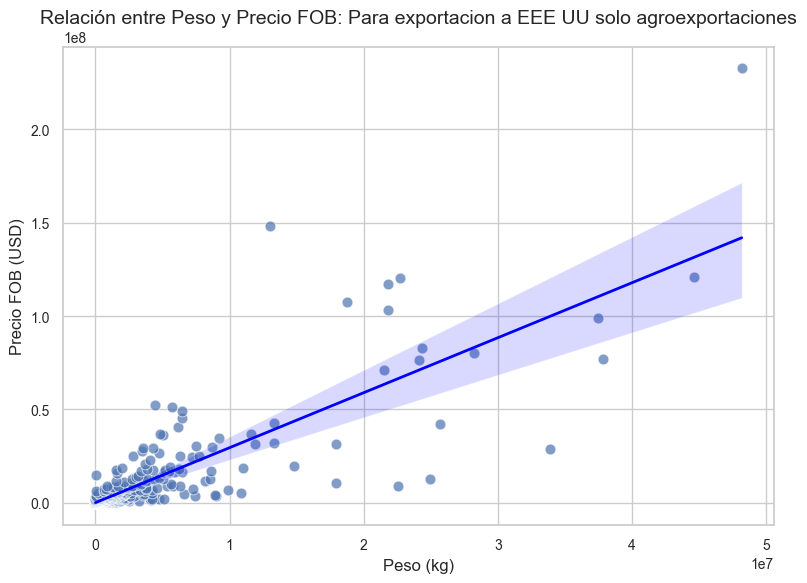

In [ ]:
## 2020=2024
df_usa = df[ (df['mercado'] == 'Estados Unidos') &  (df['sector_sunat'] == 'AGROPECUARIO') &  (df['ano'] == 2024)] 
 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

# 1. Scatter plot
sns.scatterplot(
    data=df_usa,
    x='pes_neto_kg', 
    y='fob_usd',
    s=60,
    alpha=0.7,
    ax=ax
)

# 2. Línea de ajuste (regresión lineal)
sns.regplot(
    data=df_usa,
    x='pes_neto_kg',
    y='fob_usd',
    scatter=False,
    color='blue',
    line_kws={'linewidth': 2},
    ax=ax
)

# 3. Etiquetas y título
ax.set_xlabel('Peso (kg)', fontsize=12)
ax.set_ylabel('Precio FOB (USD)', fontsize=12)
ax.set_title('Relación entre Peso y Precio FOB: Para exportacion a EEE UU solo agroexportaciones', fontsize=14)

plt.tight_layout()
 
plt.savefig('scatter_fob_vs_peso.png', dpi=300, bbox_inches='tight')

plt.show()


## Generar la variable de nombre de paises en ingles

In [14]:
import fiona
print("Fiona se importó correctamente en el entorno ai_enginering_rag")

Fiona se importó correctamente en el entorno ai_enginering_rag


In [15]:
## extraer los datos de poligonos de la web
df_poligons = gpd.read_file(
    "https://raw.githubusercontent.com/NoeMelo/geopandas-visualizacion/master/geojson/countries.geojson",
     engine="fiona"
)



In [16]:
 

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(
    model="gpt-4o-mini",  # cambia a "gpt-4o-mini" o "gpt-3.5-turbo"
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    openai_api_key=api_key
)

TRANSLATIONS_FILE = "country_translations.json"

def translate_and_region(country_name: str) -> dict:
    system_prompt = (
        "You are a professional translator specialized in geographic datasets. "
        "Translate the following country name from Spanish to English using the "
        "Natural Earth naming conventions (common English short names).\n\n"
        "Use **Title Case** for the country names, applying these rules:\n"
        "  1. Always capitalize the first and last word of the name.\n"
        "  2. Capitalize all 'major' words (nouns, pronouns, verbs, adjectives, adverbs).\n"
        "  3. **Lowercase** the following ‘minor’ words —unless they begin or end the name—:\n"
        "      • Articles: a, an, the\n"
        "      • Coordinating conjunctions: and, but, for, nor, or, so, yet\n"
        "      • Short prepositions (fewer than four letters): at, by, for, in, of, on, to, up\n\n"
        "Additionally, determine the continent (region) to which the country belongs.\n"
        "Return strictly a JSON object with exactly two keys:\n"
        "  - \"country\": the translated English name in Title Case\n"
        "  - \"region\": the continent name (Africa, North America, Central America, South America, Asia, Europe, Oceania)\n\n"
        "Do NOT include any explanation or extra text outside the JSON."
    )

    user_prompt = f"Country (Spanish): {country_name}"

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]

    response = llm.invoke(messages)
    text = response.content.strip()

    try:
        # Intento directo de decodificar el contenido
        result = json.loads(text)
    except json.JSONDecodeError:
        # Si falla, se utiliza una expresión regular para extraer el JSON del texto
        match = re.search(r'(\{.*\})', text, re.DOTALL)
        if match:
            json_str = match.group(1)
            try:
                result = json.loads(json_str)
            except json.JSONDecodeError:
                raise ValueError(f"JSON parsing error even after extraction: {json_str}")
        else:
            raise ValueError(f"JSON parsing error and no JSON structure found in the response: {text}")
    return result


In [18]:
### DO 
import re 

paises = df['mercado'].unique().tolist()

map_country = {}
map_region = {}

try:
    with open(TRANSLATIONS_FILE, 'r') as f:
        translations = json.load(f)
        map_country = translations.get('country', {})
        map_region = translations.get('region', {})
    print(f"Cargando traducciones existentes desde {TRANSLATIONS_FILE}")
except FileNotFoundError:
    print(f"El archivo {TRANSLATIONS_FILE} no encontrado. Iniciando la traducción.")
    countries = []
    regions = []
    new_translations_country = {}
    new_translations_region = {}

    for pais in tqdm(paises, desc="Traduciendo y asignando región"):
        if pais not in map_country:
            out = translate_and_region(pais)
            map_country[pais] = out['country']
            map_region[pais] = out['region']
            new_translations_country[pais] = out['country']
            new_translations_region[pais] = out['region']

    # Guardar las nuevas traducciones
    with open(TRANSLATIONS_FILE, 'w') as f:
        json.dump({'country': map_country, 'region': map_region}, f, indent=4)
    print(f"Traducciones guardadas en {TRANSLATIONS_FILE}")

#Crando las nuevas columnas:
df['mercado_traducido'] = df['mercado'].map(map_country)
df['region']            = df['mercado'].map(map_region)

# Mostramos una muestra para verificar
display(df[['mercado', 'mercado_traducido', 'region']].head())

El archivo country_translations.json no encontrado. Iniciando la traducción.


Traduciendo y asignando región: 100%|██████████| 207/207 [03:19<00:00,  1.04it/s]

Traducciones guardadas en country_translations.json


,mercado,mercado_traducido,region
925,Sudafrica,South Africa,Africa
926,Polonia,Poland,Europe
927,Colombia,Colombia,South America
928,Taiwan,Taiwan,Asia
929,Ecuador,Ecuador,South America


In [19]:
## Realizar un mapeo manual: 
mapping_dict = {
    "International Waters": "International Waters",  # Posible caso especial
    "Bahamas": "The Bahamas",  # Se unifica con "The Bahamas" en la base de polígonos
    "Bonaire, Sint Eustatius and Saba": "Bonaire, Sint Eustatius and Saba",  # Verificar si se
                                                     # desea incluir, o puede quedar como no match.
    "Congo": "Republic of Congo",  # O "Democratic Republic of the Congo". Escoge el que corresponda.
    "Curacao": "Curaçao",
    "United States": "United States of America",
    "Guadeloupe": "Guadeloupe",  # Probablemente no exista en la base de polígonos
    "Guinea-Bissau": "Guinea Bissau",
    "French Guiana": "French Guiana",  # Falta en polígonos; puede requerir un ajuste o se marcará para revisión.
    "Hong Kong": "Hong Kong S.A.R.",
    "Saint Martin - Isla de": "Saint Martin",  # Se elimina el descriptor extra.
    "Saint Barthélemy": "Saint Barthelemy",  # Ajuste de acento
    "Svalbard and Jan Mayen": "Svalbard and Jan Mayen",  # Revisa si existe o se marca
    "Macao": "Macao S.A.R",
    "North Macedonia": "Macedonia",
    "Martinique": "Martinique",  # Verificar si existe
    "Micronesia": "Federated States of Micronesia",
    "Syrian Arab Republic": "Syria",
    "Tanzania": "United Republic of Tanzania",
    "Reunion": "Reunion",  # Puede no existir; revisar
    "Serbia": "Republic of Serbia",
    "Eswatini": "Swaziland",
    "Tokelau": "Tokelau",  # Revisar si aparece en polígonos
    "Peru - Zonas Francas": "Peru - Zonas Francas",
    "Aland": "Åland Islands",
    "Bajo Nuevo Bank (Petrel Is.)": "Bajo Nuevo Bank",
    "Baykonur Cosmodrome": "Baikonur Cosmodrome",
    "Laos": "Lao PDR",
    "Russia": "Russian Federation", 
    "Sao Tome and Principe": "São Tomé and Príncipe",
    "East Timor": "Timor-Leste",
    "US Naval Base Guantanamo Bay": "United States Naval Base Guantanamo Bay",
    "Vatican": "Vatican City"
}

 
# 3. Aplicar el mapeo para generar una nueva columna con el nombre ajustado.
def adjust_name(name):
    # Si hay un valor en el mapping, lo usamos; si no, devolvemos el propio nombre
    return mapping_dict.get(name, name)

df["adjusted_name"] = df["mercado_traducido"].apply(adjust_name)



In [20]:
## Creamos datos de fob_usd como suma de todos los anios y paises
df_map = df.groupby('adjusted_name')['fob_usd'].sum().reset_index()
df_map.head(5)

,adjusted_name,fob_usd
0,Afghanistan,10734.80
1,Albania,2918206.27
2,Algeria,20670587.06
3,Angola,883079.46
4,Anguilla,63063.72


### Mapa mundial de la suma de valor fob

In [26]:
def normalize_col(series: pd.Series) -> pd.Series:
    # 1. Remove accents
    normalized = series.astype(str).apply(
        lambda x: unicodedata.normalize('NFKD', x)
    )
    # 2. Encode to ASCII, ignore non-ASCII (drops accents), then decode back to string
    normalized = normalized.str.encode('ascii', 'ignore').str.decode('utf-8')
    # 3. Lowercase
    normalized = normalized.str.lower()
    # 4. Remove any character that is not alphanumeric or space
    normalized = normalized.str.replace(r'[^a-z0-9 ]', '', regex=True)
    # 5. Strip leading/trailing whitespace
    return normalized.str.strip()


In [35]:
## Creamos datos de fob_usd como suma de todos los anios y paises
df_map = df.groupby(['adjusted_name', 'ano'])[['fob_usd']].sum().reset_index()
df_sel_year = df_map[df_map['ano'] == 2024] 

 
# Normalize key columns
df_poligons['ADMIN_norm'] = normalize_col(df_poligons['ADMIN'])
df_sel_year['adjusted_norm']   = normalize_col(df_map['adjusted_name'])
 

print(f"En cordenadas de mapa: {len(df_poligons) } y en datos sobre valor de exportaciones: {len(df_sel_year) }")



En cordenadas de mapa: 255 y en datos sobre valor de exportaciones: 178


In [37]:
# Merge on normalized columns
data_merge = pd.merge(
    df_poligons,
    df_sel_year,
    how='left',
    left_on='ADMIN_norm',
    right_on='adjusted_norm'
)


display(data_merge.head(2))


# Preview the first two rows
print(f"Los datos de merge tienen {len(data_merge)} filas")
print(f"Los datos de merge tienen {data_merge['adjusted_norm'].notna().sum()} filas que no son nulos en fob")
 
 

,ADMIN,ISO_A3,ISO_A2,geometry,ADMIN_norm,adjusted_name,ano,fob_usd,adjusted_norm
0,Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ...",aruba,Aruba,2024.0,7210902.7,aruba
1,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.0498 38.40866, 71.05714 38....",afghanistan,NaN,NaN,NaN,NaN


Los datos de merge tienen 255 filas
Los datos de merge tienen 168 filas que no son nulos en fob


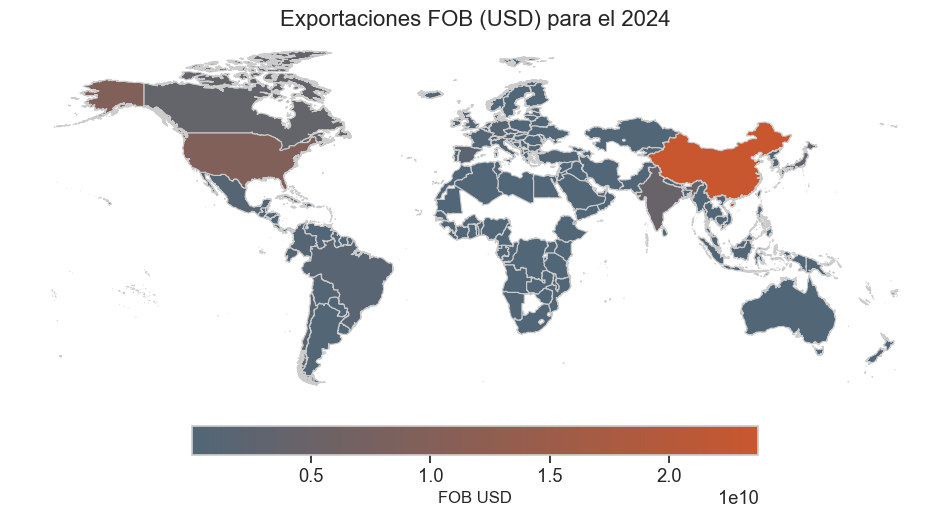

In [39]:
# Definir colormap personalizado: aquí se define una paleta que va de un color a otro.
cmap_colors = ['#516677', '#c8572f']  # Puedes ajustar los colores según tus preferencias
cmap = LinearSegmentedColormap.from_list('CustomMap', cmap_colors)

df_plot = data_merge[~data_merge['ADMIN'].isin(["Antarctica", "Svalbard and Jan Mayen"])].copy()


# Ordenar el DataFrame por 'fob_usd' (de menor a mayor, por ejemplo)
df_plot.sort_values('fob_usd', ascending=True, inplace=True)

# Crear la figura y el eje
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Graficar el GeoDataFrame usando la columna 'fob_usd'
df_plot.plot(column='fob_usd',
              cmap=cmap,
              linewidth=0.8,
              ax=ax,
              edgecolor='0.8',
              legend=False)

# Configurar el título y quitar ejes
ax.set_title("Exportaciones FOB (USD) para el 2024", fontsize=16)
ax.axis('off')

# Configurar la barra de color
norm = mcolors.Normalize(vmin=df_plot['fob_usd'].min(), vmax=df_plot['fob_usd'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Requerido para versiones antiguas de matplotlib

# Ubicar la barra en la parte inferior del gráfico, en orientación horizontal.
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label("FOB USD", fontsize=12)

# Mostrar el gráfico
plt.show()

In [ ]:
# Paleta y normalización comunes
cmap_colors = ['#516677', '#c8572f']
cmap = LinearSegmentedColormap.from_list('CustomMap', cmap_colors)
years = [2021, 2022, 2023, 2024]

# Letras para los subplots
letters = ['A', 'B', 'C', 'D']

# Asegúrate de tener ya normalizadas las columnas
df_poligons['ADMIN_norm']   = normalize_col(df_poligons['ADMIN'])
df_map['adjusted_norm']     = normalize_col(df_map['adjusted_name'])

# Escala común
mask_years = df_map['ano'].isin(years)
min_val = df_map.loc[mask_years, 'fob_usd'].min()
max_val = df_map.loc[mask_years, 'fob_usd'].max()
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

# Crear figura y ejes 2×2
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, year in enumerate(years):
    ax = axs[i]
    # Filtrar y mergear
    df_sel   = df_map[df_map['ano'] == year]
    df_merge = pd.merge(
        df_poligons, df_sel,
        how='left',
        left_on='ADMIN_norm',
        right_on='adjusted_norm'
    )
    df_plot = df_merge[~df_merge['ADMIN'].isin(
        ["Antarctica", "Svalbard and Jan Mayen"]
    )].copy()
    df_plot.sort_values('fob_usd', ascending=True, inplace=True)
    
    # Plot
    df_plot.plot(
        column='fob_usd',
        cmap=cmap,
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        norm=norm,
        legend=False
    )
    # Título con letra identificadora
    ax.set_title(f"{letters[i]}) Exportaciones FOB ({year})",
                 fontsize=12, loc='left')
    ax.axis('off')

# Crear un eje pequeño al fondo para la barra de color
# [left, bottom, width, height] en fracción de la figura
cbar_ax = fig.add_axes([0.3, 0.02, 0.4, 0.02])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # work‐around
fig.colorbar(
    sm,
    cax=cbar_ax,
    orientation='horizontal',
    label='FOB USD'
)

# Ajustar layout dejando espacio para la colorbar
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
